# Alignment of EM sections

This notebook shows how to use SOFIMA to elastically align ultrathin sections of brain tissue acquired with an electron microscope. We will be using a 5000x5000x200 subset of a SBEM dataset of zebrafish brain acquired in Rainer Friedrich's lab at the FMI. You can browse the [unaligned data](https://neuroglancer-demo.appspot.com/#!%7B%22dimensions%22:%7B%22x%22:%5B1.1e-8%2C%22m%22%5D%2C%22y%22:%5B1.1e-8%2C%22m%22%5D%2C%22z%22:%5B2.5e-8%2C%22m%22%5D%7D%2C%22position%22:%5B2359.354248046875%2C2653.44775390625%2C99.5%5D%2C%22crossSectionScale%22:3.5180938094527145%2C%22projectionScale%22:8192%2C%22layers%22:%5B%7B%22type%22:%22image%22%2C%22source%22:%22precomputed://gs://sofima-sample-data/fmi-friedrich-dp/subvol_5800_5500_6250%22%2C%22tab%22:%22source%22%2C%22name%22:%22subvol_5800_5500_6250%22%7D%5D%2C%22selectedLayer%22:%7B%22visible%22:true%2C%22layer%22:%22subvol_5800_5500_6250%22%7D%2C%22layout%22:%224panel%22%7D) in Neuroglancer.

In [1]:
!pip install tensorstore
import tensorstore as ts

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
storage_dir = "/content/drive/MyDrive/batch_004_4096_1_ts"  # 替换成你本地存储路径

unaligned_1x = ts.open({
    'driver': 'neuroglancer_precomputed',
    'kvstore': f'file://{storage_dir}',
    'scale_metadata': {"resolution": [8, 8, 8]},
    'context': { "cache_pool": {"total_bytes_limit": 1_000_000_000},}
}).result()

In [5]:
# Precomputed volume, 2x downsampled resolution. Downsampling was done with area averaging.
unaligned_2x = ts.open({
    'driver': 'neuroglancer_precomputed',
    'kvstore': f'file://{storage_dir}',
    'scale_metadata': {"resolution": [16, 16, 16]},
    'context': { "cache_pool": {"total_bytes_limit": 1_000_000_000},}
}).result()

In [6]:
unaligned_1x.shape

(4096, 4096, 200, 1)

In [7]:
!pip install git+https://github.com/google-research/sofima

  Cloning https://github.com/google-research/sofima to /tmp/pip-req-build-bksah4am
  Running command git clone --filter=blob:none --quiet https://github.com/google-research/sofima /tmp/pip-req-build-bksah4am
  Resolved https://github.com/google-research/sofima to commit 52a730b70fc49661bdb21d011b70bceb601d468b
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.0/3.0 MB 84.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 271.1/271.1 kB 22.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.9/50.9 kB 4.4 MB/s eta 0:00:00
  Created wheel for sofima: filename=sofima-20240120.dev45+g52a730b70-py3-none-any.whl size=93329 sha256=d3dc17853b0078f3d22a81e7ed3f80471d181fb1aec45b3480f640ea0862536a
  Stored in directory: /tmp/pip-ephem-wheel-cache-6phos9f8/wheels/27/2b/6a/ec514a660f0e3d29b8022931741c441aaeefc9dd98779ba549
Successfully built so

In [8]:
from concurrent import futures
import time

import jax
import jax.numpy as jnp
import numpy as np
import matplotlib.pyplot as plt

from connectomics.common import bounding_box
from sofima import flow_field
from sofima import flow_utils
from sofima import map_utils
from sofima import mesh
from sofima import warp
from tqdm.notebook import tqdm

In [9]:
# Ensure that we're running this code on a GPU machine. If this fails and you're using
# Google Colab, use "Edit >> Notebook settings" and set s"Hardware accelerator" to "GPU".
assert jax.devices()[0].platform == 'gpu'

# Flow field estimation

First, we calculate the flow fields between the current section and the directly preceding section. Flow fields can also be computed between pairs of sections that are not directly adjacent. This is useful if sections are incomplete or missing, but is not something we have to worry about in this demo.

In a distributed environment, this step would be done with the `EstimateFlow` processor.


On a V100, the expected time for the flow calculation over a single 5000x5000 section with the settings below, is ~0.6s. The patch (160) and step (40) sizes are set to conservative values which work for most synaptic-resolution EM volumes (i.e. at an in-plane resolution of ~10 nm/px).


In [10]:
# Both of the settings below are expressed in pixels.
patch_size = 160  # XY spatial context used for flow field estimation
stride = 40  # XY distance between centers of adjacent patches.

def _compute_flow(volume):
  mfc = flow_field.JAXMaskedXCorrWithStatsCalculator()
  flows = []
  prev = volume[..., 0, 0].T.read().result()

  fs = []
  with futures.ThreadPoolExecutor() as tpe:
    # Prefetch the next sections to memory so that we don't have to wait for them
    # to load when the GPU becomes available.
    for z in range(1, unaligned_1x.shape[2]):
      fs.append(tpe.submit(lambda z=z: volume[..., z, 0].T.read().result()))

    fs = fs[::-1]

    for z in tqdm(range(1, unaligned_1x.shape[2])):
      curr = fs.pop().result()

      # The batch size is a parameter which impacts the efficiency of the computation (but
      # not its result). It has to be large enough for the computation to fully utilize the
      # available GPU capacity, but small enough so that the batch fits in GPU RAM.
      flows.append(mfc.flow_field(prev, curr, (patch_size, patch_size),
                                  (stride, stride), batch_size=256))
      prev = curr

  return flows

Compute flows at native and 2x reduced in-plane resolution. The lower resolution flow has reduced precision, but is helpful for providing approximate flow vectors in places where the full-resolution flow might be impossible to estimate, e.g. in the interior of cell bodies or blood vessels.


In [11]:
flows1x = np.array(_compute_flow(unaligned_1x))
flows2x = np.array(_compute_flow(unaligned_2x))

  0%|          | 0/199 [00:00<?, ?it/s]

  0%|          | 0/199 [00:00<?, ?it/s]

The flow fields generated in the previous step are 4-channel arrays, where the first two channels store the XY components of the flow vector, and the two remaining channels are measures of estimation quality (see `sofima.flow_field._batched_peaks` for more info).

In [12]:
# Convert to [channels, z, y, x].
flows2x = np.transpose(flows2x, [1, 0, 2, 3])
flows1x = np.transpose(flows1x, [1, 0, 2, 3])

# Pad to account for the edges of the images where there is insufficient context to estimate flow.
pad = patch_size // 2 // stride
flows1x = np.pad(flows1x, [[0, 0], [0, 0], [pad, pad], [pad, pad]], constant_values=np.nan)
flows2x = np.pad(flows2x, [[0, 0], [0, 0], [pad, pad], [pad, pad]], constant_values=np.nan)
print(flows1x.shape, flows2x.shape)

(4, 199, 103, 103) (4, 199, 52, 52)


We now remove uncertain flow estimates by replacing them with NaNs, and merge the two flow arrays into a single flow field at full resolution. In a distributed environment, this step would be done with the `ReconcileAndFilterFlows` processor.

In [13]:
f1 = flow_utils.clean_flow(flows1x, min_peak_ratio=1.6, min_peak_sharpness=1.6, max_magnitude=80, max_deviation=20)
f2 = flow_utils.clean_flow(flows2x, min_peak_ratio=1.6, min_peak_sharpness=1.6, max_magnitude=80, max_deviation=20)
print(f1.shape, f2.shape)

(2, 199, 103, 103) (2, 199, 52, 52)


Plot the horizontal component of the flow vector, before (left) and after (right) filtering. While blobs indicate areas where uncertain flow estimates were removed.

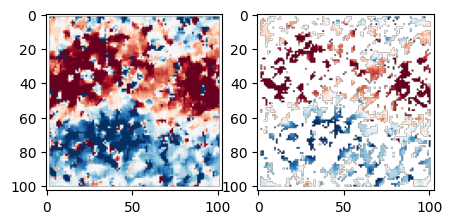

In [14]:
f, ax = plt.subplots(1, 2, figsize=(5, 2.5))
ax[0].imshow(flows1x[0, 14, ...], cmap=plt.cm.RdBu, vmin=-10, vmax=10)
ax[1].imshow(f1[0, 14, ...], cmap=plt.cm.RdBu, vmin=-10, vmax=10)

In [15]:
from scipy import interpolate
f2_hires = np.zeros_like(f1)

scale = 0.5
oy, ox = np.ogrid[:f2.shape[-2], :f2.shape[-1]]
oy = oy.ravel() / scale
ox = ox.ravel() / scale

box1x = bounding_box.BoundingBox(start=(0, 0, 0), size=(f1.shape[-1], f1.shape[-2], 1))
box2x = bounding_box.BoundingBox(start=(0, 0, 0), size=(f2.shape[-1], f2.shape[-2], 1))

for z in tqdm(range(f2.shape[1])):
  # Upsample and scale spatial components.
  resampled = map_utils.resample_map(
      f2[:, z:z + 1, ...],  #
      box2x, box1x, 1 / scale, 1)
  f2_hires[:, z:z + 1, ...] = resampled / scale

  0%|          | 0/199 [00:00<?, ?it/s]

In [16]:
final_flow = flow_utils.reconcile_flows((f1, f2_hires), max_gradient=0, max_deviation=20, min_patch_size=400)

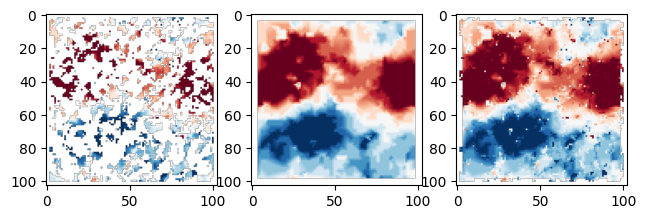

In [17]:
# Plot (left to right): high res. flow, upsampled low res. flow, combined flow to use for alignment.
f, ax = plt.subplots(1, 3, figsize=(7.5, 2.5))
ax[0].imshow(f1[0, 14, ...], cmap=plt.cm.RdBu, vmin=-10, vmax=10)
ax[1].imshow(f2_hires[0, 14, ...], cmap=plt.cm.RdBu, vmin=-10, vmax=10)
ax[2].imshow(final_flow[0, 14, ...], cmap=plt.cm.RdBu, vmin=-10, vmax=10)

# Mesh optimization

We use an elastic mesh optimizer to find a configuration of the imagery that is compatible with the estimated flow field and preserves the original geometry as much as possible.

The optimization proceeds sequentially, section by section. In a distributed environment, this computation can be parallelized across the plane (by independently solving overlapping XY tiles), as well as split into blocks along the Z axis. This makes it possible to scale this process to arbitrarily large volumes. For simplicity, here we solve the complete stack in one go.

In [18]:
config = mesh.IntegrationConfig(dt=0.001, gamma=0.0, k0=0.01, k=0.1, stride=(stride, stride), num_iters=1000,
                                max_iters=100000, stop_v_max=0.005, dt_max=1000, start_cap=0.01,
                                final_cap=10, prefer_orig_order=True)

In [19]:
solved = [np.zeros_like(final_flow[:, 0:1, ...])]
origin = jnp.array([0., 0.])

for z in tqdm(range(0, final_flow.shape[1])):
  prev = map_utils.compose_maps_fast(final_flow[:, z:z+1, ...], origin, stride,
                                     solved[-1], origin, stride)
  x = np.zeros_like(solved[0])
  x, e_kin, num_steps = mesh.relax_mesh(x, prev, config)
  x = np.array(x)
  solved.append(x)

  0%|          | 0/199 [00:00<?, ?it/s]

In [20]:
solved = np.concatenate(solved, axis=1)

# Image warping

Image warping requires an inverse coordinate map, so compute that first. In a distributed environment, this can be done with the `InvertMap` processor.

In [22]:
inv_map = map_utils.invert_map(solved, box1x, box1x, stride)
print(inv_map.shape)

(2, 200, 103, 103)


We are now ready to render the aligned subvolume. To reduce RAM usage, we render a 1000x1000 part for all 200 sections.

In a distributed environment, this can be done with the `WarpByMap` processor.

In [23]:
# warped = [np.transpose(unaligned_1x[1000:2000, 2000:3000, 0:1, 0].read().result(), [2, 1, 0])]

# for z in tqdm(range(1, unaligned_1x.shape[2])):
#   data_box = bounding_box.BoundingBox(start=(500, 1500, 0), size=(2000, 2000, 1))
#   out_box = bounding_box.BoundingBox(start=(1000, 2000, 0), size=(1000, 1000, 1))

#   data = np.transpose(unaligned_1x[data_box.start[0]:data_box.end[0],
#                                    data_box.start[1]:data_box.end[1],
#                                    z:z+1, 0:1].read().result(), [3, 2, 1, 0])
#   warped.append(
#       warp.warp_subvolume(data, data_box, inv_map[:, z:z+1, ...], box1x, stride, out_box, 'lanczos', parallelism=1)[0, ...])


warped = [np.transpose(unaligned_1x[:, :, 0:1, 0].read().result(), [2, 1, 0])]

for z in tqdm(range(1, unaligned_1x.shape[2])):  # 遍历所有的z轴切片
    data_box = bounding_box.BoundingBox(start=(0, 0, 0), size=(unaligned_1x.shape[0], unaligned_1x.shape[1], 1))
    out_box = bounding_box.BoundingBox(start=(0, 0, 0), size=(unaligned_1x.shape[0], unaligned_1x.shape[1], 1))

    # 读取整个数据集的子区域
    data = np.transpose(unaligned_1x[data_box.start[0]:data_box.end[0],
                                     data_box.start[1]:data_box.end[1],
                                     z:z+1, 0:1].read().result(), [3, 2, 1, 0])

    # 进行变换
    warped.append(
        warp.warp_subvolume(data, data_box, inv_map[:, z:z+1, ...], box1x, stride, out_box, 'lanczos', parallelism=1)[0, ...])

# 现在 warped 包含了所有的变形数据


  0%|          | 0/199 [00:00<?, ?it/s]

In [24]:
warped_xyz = np.transpose(np.concatenate(warped, axis=0), [2, 1, 0])
print(warped_xyz.shape)

(4096, 4096, 200)


In [25]:
print(len(warped))
print(warped[0].shape)

200
(1, 4096, 4096)


In [26]:
import os
import numpy as np
from PIL import Image
from tqdm import tqdm

def save_warped_to_png(warped_data, output_folder):
    """
    将 warped 数据（每个数据块）保存为 PNG 图像到指定文件夹。

    参数:
    - warped_data: 一个包含变形数据块的列表或数组
    - output_folder: 存储 PNG 图像的文件夹路径
    - prefix: 保存图像时使用的文件名前缀 (默认为 "warped")

    返回:
    - None
    """
    # 创建存储文件夹（如果不存在）
    os.makedirs(output_folder, exist_ok=True)

    # 逐个保存 warped 数据块为 PNG 文件
    for i, data in tqdm(enumerate(warped_data), desc="Saving PNGs"):
        # 将数据转换为整数类型，并确保其范围适合 PNG 图像
        data = data[0]
        data = np.array(data, dtype=np.uint8)
        # 如果数据是多通道图像（例如 RGB），将其转换为适当的格式
        if len(data.shape) == 3 and data.shape[2] == 3:  # RGB图像
            image = Image.fromarray(data)
        else:  # 单通道图像
            image = Image.fromarray(data)

        # 构造输出文件路径
        output_path = os.path.join(output_folder, f"{i:04d}.png")

        # 保存为 PNG 文件
        image.save(output_path)

    print(f"All PNG images saved successfully in {output_folder}")

# 示例调用
save_warped_to_png(warped, "/content/drive/MyDrive/batch_004_4096_1_reg")


Saving PNGs: 0it [00:00, ?it/s]

(4096, 4096)


Saving PNGs: 1it [00:02,  2.35s/it]

(4096, 4096)


Saving PNGs: 2it [00:04,  2.07s/it]

(4096, 4096)


Saving PNGs: 3it [00:05,  1.81s/it]

(4096, 4096)


Saving PNGs: 4it [00:07,  1.73s/it]

(4096, 4096)


Saving PNGs: 5it [00:08,  1.65s/it]

(4096, 4096)


Saving PNGs: 6it [00:10,  1.62s/it]

(4096, 4096)


Saving PNGs: 7it [00:12,  1.62s/it]

(4096, 4096)


Saving PNGs: 8it [00:13,  1.62s/it]

(4096, 4096)


Saving PNGs: 9it [00:15,  1.78s/it]

(4096, 4096)


Saving PNGs: 10it [00:17,  1.78s/it]

(4096, 4096)


Saving PNGs: 11it [00:19,  1.68s/it]

(4096, 4096)


Saving PNGs: 12it [00:20,  1.63s/it]

(4096, 4096)


Saving PNGs: 13it [00:21,  1.58s/it]

(4096, 4096)


Saving PNGs: 14it [00:23,  1.56s/it]

(4096, 4096)


Saving PNGs: 15it [00:24,  1.54s/it]

(4096, 4096)


Saving PNGs: 16it [00:26,  1.53s/it]

(4096, 4096)


Saving PNGs: 17it [00:28,  1.60s/it]

(4096, 4096)


Saving PNGs: 18it [00:30,  1.67s/it]

(4096, 4096)


Saving PNGs: 19it [00:31,  1.63s/it]

(4096, 4096)


Saving PNGs: 20it [00:33,  1.61s/it]

(4096, 4096)


Saving PNGs: 21it [00:34,  1.61s/it]

(4096, 4096)


Saving PNGs: 22it [00:36,  1.54s/it]

(4096, 4096)


Saving PNGs: 23it [00:37,  1.57s/it]

(4096, 4096)


Saving PNGs: 24it [00:39,  1.56s/it]

(4096, 4096)


Saving PNGs: 25it [00:41,  1.70s/it]

(4096, 4096)


Saving PNGs: 26it [00:43,  1.74s/it]

(4096, 4096)


Saving PNGs: 27it [00:44,  1.70s/it]

(4096, 4096)


Saving PNGs: 28it [00:46,  1.67s/it]

(4096, 4096)


Saving PNGs: 29it [00:48,  1.66s/it]

(4096, 4096)


Saving PNGs: 30it [00:49,  1.68s/it]

(4096, 4096)


Saving PNGs: 31it [00:51,  1.65s/it]

(4096, 4096)


Saving PNGs: 32it [00:53,  1.64s/it]

(4096, 4096)


Saving PNGs: 33it [00:55,  1.76s/it]

(4096, 4096)


Saving PNGs: 34it [00:56,  1.77s/it]

(4096, 4096)


Saving PNGs: 35it [00:58,  1.71s/it]

(4096, 4096)


Saving PNGs: 36it [00:59,  1.67s/it]

(4096, 4096)


Saving PNGs: 37it [01:01,  1.63s/it]

(4096, 4096)


Saving PNGs: 38it [01:03,  1.63s/it]

(4096, 4096)


Saving PNGs: 39it [01:04,  1.61s/it]

(4096, 4096)


Saving PNGs: 40it [01:06,  1.64s/it]

(4096, 4096)


Saving PNGs: 41it [01:08,  1.75s/it]

(4096, 4096)


Saving PNGs: 42it [01:10,  1.76s/it]

(4096, 4096)


Saving PNGs: 43it [01:11,  1.72s/it]

(4096, 4096)


Saving PNGs: 44it [01:13,  1.68s/it]

(4096, 4096)


Saving PNGs: 45it [01:15,  1.68s/it]

(4096, 4096)


Saving PNGs: 46it [01:16,  1.69s/it]

(4096, 4096)


Saving PNGs: 47it [01:18,  1.67s/it]

(4096, 4096)


Saving PNGs: 48it [01:20,  1.75s/it]

(4096, 4096)


Saving PNGs: 49it [01:22,  1.80s/it]

(4096, 4096)


Saving PNGs: 50it [01:23,  1.74s/it]

(4096, 4096)


Saving PNGs: 51it [01:25,  1.69s/it]

(4096, 4096)


Saving PNGs: 52it [01:27,  1.64s/it]

(4096, 4096)


Saving PNGs: 53it [01:28,  1.62s/it]

(4096, 4096)


Saving PNGs: 54it [01:30,  1.62s/it]

(4096, 4096)


Saving PNGs: 55it [01:31,  1.62s/it]

(4096, 4096)


Saving PNGs: 56it [01:33,  1.75s/it]

(4096, 4096)


Saving PNGs: 57it [01:35,  1.77s/it]

(4096, 4096)


Saving PNGs: 58it [01:37,  1.71s/it]

(4096, 4096)


Saving PNGs: 59it [01:38,  1.66s/it]

(4096, 4096)


Saving PNGs: 60it [01:40,  1.62s/it]

(4096, 4096)


Saving PNGs: 61it [01:41,  1.59s/it]

(4096, 4096)


Saving PNGs: 62it [01:43,  1.56s/it]

(4096, 4096)


Saving PNGs: 63it [01:44,  1.57s/it]

(4096, 4096)


Saving PNGs: 64it [01:46,  1.71s/it]

(4096, 4096)


Saving PNGs: 65it [01:48,  1.73s/it]

(4096, 4096)


Saving PNGs: 66it [01:50,  1.68s/it]

(4096, 4096)


Saving PNGs: 67it [01:51,  1.64s/it]

(4096, 4096)


Saving PNGs: 68it [01:53,  1.63s/it]

(4096, 4096)


Saving PNGs: 69it [01:54,  1.60s/it]

(4096, 4096)


Saving PNGs: 70it [01:56,  1.59s/it]

(4096, 4096)


Saving PNGs: 71it [01:58,  1.57s/it]

(4096, 4096)


Saving PNGs: 72it [02:00,  1.73s/it]

(4096, 4096)


Saving PNGs: 73it [02:01,  1.75s/it]

(4096, 4096)


Saving PNGs: 74it [02:03,  1.69s/it]

(4096, 4096)


Saving PNGs: 75it [02:05,  1.66s/it]

(4096, 4096)


Saving PNGs: 76it [02:06,  1.64s/it]

(4096, 4096)


Saving PNGs: 77it [02:08,  1.61s/it]

(4096, 4096)


Saving PNGs: 78it [02:09,  1.60s/it]

(4096, 4096)


Saving PNGs: 79it [02:11,  1.59s/it]

(4096, 4096)


Saving PNGs: 80it [02:13,  1.72s/it]

(4096, 4096)


Saving PNGs: 81it [02:15,  1.74s/it]

(4096, 4096)


Saving PNGs: 82it [02:16,  1.67s/it]

(4096, 4096)


Saving PNGs: 83it [02:18,  1.64s/it]

(4096, 4096)


Saving PNGs: 84it [02:19,  1.60s/it]

(4096, 4096)


Saving PNGs: 85it [02:21,  1.57s/it]

(4096, 4096)


Saving PNGs: 86it [02:22,  1.55s/it]

(4096, 4096)


Saving PNGs: 87it [02:24,  1.58s/it]

(4096, 4096)


Saving PNGs: 88it [02:26,  1.70s/it]

(4096, 4096)


Saving PNGs: 89it [02:28,  1.71s/it]

(4096, 4096)


Saving PNGs: 90it [02:29,  1.67s/it]

(4096, 4096)


Saving PNGs: 91it [02:31,  1.63s/it]

(4096, 4096)


Saving PNGs: 92it [02:32,  1.58s/it]

(4096, 4096)


Saving PNGs: 93it [02:34,  1.59s/it]

(4096, 4096)


Saving PNGs: 94it [02:35,  1.56s/it]

(4096, 4096)


Saving PNGs: 95it [02:37,  1.57s/it]

(4096, 4096)


Saving PNGs: 96it [02:39,  1.69s/it]

(4096, 4096)


Saving PNGs: 97it [02:41,  1.70s/it]

(4096, 4096)


Saving PNGs: 98it [02:42,  1.66s/it]

(4096, 4096)


Saving PNGs: 99it [02:44,  1.67s/it]

(4096, 4096)


Saving PNGs: 100it [02:45,  1.63s/it]

(4096, 4096)


Saving PNGs: 101it [02:47,  1.59s/it]

(4096, 4096)


Saving PNGs: 102it [02:48,  1.56s/it]

(4096, 4096)


Saving PNGs: 103it [02:50,  1.57s/it]

(4096, 4096)


Saving PNGs: 104it [02:52,  1.66s/it]

(4096, 4096)


Saving PNGs: 105it [02:54,  1.70s/it]

(4096, 4096)


Saving PNGs: 106it [02:55,  1.64s/it]

(4096, 4096)


Saving PNGs: 107it [02:57,  1.60s/it]

(4096, 4096)


Saving PNGs: 108it [02:58,  1.56s/it]

(4096, 4096)


Saving PNGs: 109it [03:00,  1.54s/it]

(4096, 4096)


Saving PNGs: 110it [03:01,  1.52s/it]

(4096, 4096)


Saving PNGs: 111it [03:03,  1.51s/it]

(4096, 4096)


Saving PNGs: 112it [03:05,  1.65s/it]

(4096, 4096)


Saving PNGs: 113it [03:06,  1.71s/it]

(4096, 4096)


Saving PNGs: 114it [03:08,  1.64s/it]

(4096, 4096)


Saving PNGs: 115it [03:09,  1.60s/it]

(4096, 4096)


Saving PNGs: 116it [03:11,  1.55s/it]

(4096, 4096)


Saving PNGs: 117it [03:12,  1.54s/it]

(4096, 4096)


Saving PNGs: 118it [03:14,  1.53s/it]

(4096, 4096)


Saving PNGs: 119it [03:15,  1.54s/it]

(4096, 4096)


Saving PNGs: 120it [03:17,  1.65s/it]

(4096, 4096)


Saving PNGs: 121it [03:19,  1.73s/it]

(4096, 4096)


Saving PNGs: 122it [03:21,  1.68s/it]

(4096, 4096)


Saving PNGs: 123it [03:22,  1.64s/it]

(4096, 4096)


Saving PNGs: 124it [03:24,  1.60s/it]

(4096, 4096)


Saving PNGs: 125it [03:25,  1.57s/it]

(4096, 4096)


Saving PNGs: 126it [03:27,  1.56s/it]

(4096, 4096)


Saving PNGs: 127it [03:28,  1.54s/it]

(4096, 4096)


Saving PNGs: 128it [03:30,  1.65s/it]

(4096, 4096)


Saving PNGs: 129it [03:32,  1.72s/it]

(4096, 4096)


Saving PNGs: 130it [03:34,  1.67s/it]

(4096, 4096)


Saving PNGs: 131it [03:35,  1.62s/it]

(4096, 4096)


Saving PNGs: 132it [03:37,  1.61s/it]

(4096, 4096)


Saving PNGs: 133it [03:38,  1.57s/it]

(4096, 4096)


Saving PNGs: 134it [03:40,  1.57s/it]

(4096, 4096)


Saving PNGs: 135it [03:41,  1.55s/it]

(4096, 4096)


Saving PNGs: 136it [03:43,  1.64s/it]

(4096, 4096)


Saving PNGs: 137it [03:45,  1.75s/it]

(4096, 4096)


Saving PNGs: 138it [03:47,  1.71s/it]

(4096, 4096)


Saving PNGs: 139it [03:48,  1.67s/it]

(4096, 4096)


Saving PNGs: 140it [03:50,  1.64s/it]

(4096, 4096)


Saving PNGs: 141it [03:52,  1.64s/it]

(4096, 4096)


Saving PNGs: 142it [03:53,  1.63s/it]

(4096, 4096)


Saving PNGs: 143it [03:55,  1.62s/it]

(4096, 4096)


Saving PNGs: 144it [03:57,  1.75s/it]

(4096, 4096)


Saving PNGs: 145it [03:59,  1.80s/it]

(4096, 4096)


Saving PNGs: 146it [04:00,  1.74s/it]

(4096, 4096)


Saving PNGs: 147it [04:02,  1.69s/it]

(4096, 4096)


Saving PNGs: 148it [04:04,  1.67s/it]

(4096, 4096)


Saving PNGs: 149it [04:05,  1.65s/it]

(4096, 4096)


Saving PNGs: 150it [04:07,  1.62s/it]

(4096, 4096)


Saving PNGs: 151it [04:09,  1.65s/it]

(4096, 4096)


Saving PNGs: 152it [04:11,  1.78s/it]

(4096, 4096)


Saving PNGs: 153it [04:12,  1.75s/it]

(4096, 4096)


Saving PNGs: 154it [04:14,  1.69s/it]

(4096, 4096)


Saving PNGs: 155it [04:15,  1.68s/it]

(4096, 4096)


Saving PNGs: 156it [04:17,  1.64s/it]

(4096, 4096)


Saving PNGs: 157it [04:19,  1.61s/it]

(4096, 4096)


Saving PNGs: 158it [04:20,  1.60s/it]

(4096, 4096)


Saving PNGs: 159it [04:22,  1.66s/it]

(4096, 4096)


Saving PNGs: 160it [04:24,  1.82s/it]

(4096, 4096)


Saving PNGs: 161it [04:26,  1.76s/it]

(4096, 4096)


Saving PNGs: 162it [04:27,  1.73s/it]

(4096, 4096)


Saving PNGs: 163it [04:29,  1.69s/it]

(4096, 4096)


Saving PNGs: 164it [04:31,  1.64s/it]

(4096, 4096)


Saving PNGs: 165it [04:32,  1.62s/it]

(4096, 4096)


Saving PNGs: 166it [04:34,  1.61s/it]

(4096, 4096)


Saving PNGs: 167it [04:36,  1.69s/it]

(4096, 4096)


Saving PNGs: 168it [04:38,  1.79s/it]

(4096, 4096)


Saving PNGs: 169it [04:39,  1.72s/it]

(4096, 4096)


Saving PNGs: 170it [04:41,  1.69s/it]

(4096, 4096)


Saving PNGs: 171it [04:42,  1.64s/it]

(4096, 4096)


Saving PNGs: 172it [04:44,  1.60s/it]

(4096, 4096)


Saving PNGs: 173it [04:45,  1.59s/it]

(4096, 4096)


Saving PNGs: 174it [04:47,  1.59s/it]

(4096, 4096)


Saving PNGs: 175it [04:49,  1.71s/it]

(4096, 4096)


Saving PNGs: 176it [04:51,  1.76s/it]

(4096, 4096)


Saving PNGs: 177it [04:52,  1.70s/it]

(4096, 4096)


Saving PNGs: 178it [04:54,  1.63s/it]

(4096, 4096)


Saving PNGs: 179it [04:55,  1.63s/it]

(4096, 4096)


Saving PNGs: 180it [04:57,  1.63s/it]

(4096, 4096)


Saving PNGs: 181it [04:59,  1.62s/it]

(4096, 4096)


Saving PNGs: 182it [05:00,  1.60s/it]

(4096, 4096)


Saving PNGs: 183it [05:02,  1.73s/it]

(4096, 4096)


Saving PNGs: 184it [05:04,  1.75s/it]

(4096, 4096)


Saving PNGs: 185it [05:06,  1.71s/it]

(4096, 4096)


Saving PNGs: 186it [05:07,  1.68s/it]

(4096, 4096)


Saving PNGs: 187it [05:09,  1.63s/it]

(4096, 4096)


Saving PNGs: 188it [05:10,  1.63s/it]

(4096, 4096)


Saving PNGs: 189it [05:12,  1.60s/it]

(4096, 4096)


Saving PNGs: 190it [05:14,  1.62s/it]

(4096, 4096)


Saving PNGs: 191it [05:16,  1.74s/it]

(4096, 4096)


Saving PNGs: 192it [05:17,  1.72s/it]

(4096, 4096)


Saving PNGs: 193it [05:19,  1.67s/it]

(4096, 4096)


Saving PNGs: 194it [05:20,  1.63s/it]

(4096, 4096)


Saving PNGs: 195it [05:22,  1.60s/it]

(4096, 4096)


Saving PNGs: 196it [05:24,  1.58s/it]

(4096, 4096)


Saving PNGs: 197it [05:25,  1.58s/it]

(4096, 4096)


Saving PNGs: 198it [05:27,  1.61s/it]

(4096, 4096)


Saving PNGs: 199it [05:29,  1.74s/it]

(4096, 4096)


Saving PNGs: 200it [05:30,  1.65s/it]

All PNG images saved successfully in /content/drive/MyDrive/batch_004_4096_1_reg


Render an XZ cross section to check the quality of the alignment visually.

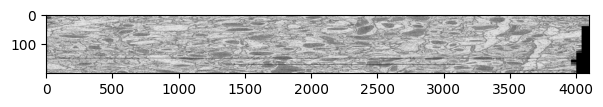

In [27]:
plt.figure(figsize=(7, 3))
plt.imshow(warped_xyz[:, 500, :].T, cmap=plt.cm.Greys_r, aspect=(1000 * 11) / (200 * 25))

The results can be inspected interactively in Neuroglancer as well.

In [28]:
!pip install neuroglancer
import neuroglancer

dimensions = neuroglancer.CoordinateSpace(names=['x', 'y', 'z'], units='nm', scales=[11, 11, 25])
viewer = neuroglancer.Viewer()
with viewer.txn() as s:
  s.dimensions = dimensions
  s.layers['em'] = neuroglancer.ImageLayer(source=neuroglancer.LocalVolume(warped_xyz, dimensions))

viewer

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.0/6.0 MB 63.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 135.2/135.2 kB 14.6 MB/s eta 0:00:00
  Created wheel for atomicwrites: filename=atomicwrites-1.4.1-py2.py3-none-any.whl size=6943 sha256=4ac86417e1e4be003eaa7ed5b2a9ddafdaa2fbc5e93e405bb1be963988cb03b0
  Stored in directory: /root/.cache/pip/wheels/6b/37/a4/ae30755673c2d1e07228f13b4491fcaef62438f771d5012d07
Successfully built atomicwrites


https://r1aj5iue98b-496ff2e9c6d22116-39113-colab.googleusercontent.com//v/80016d35c16905f63d50659244badf09401af255/

# Distributed mesh optimization

The serial mesh optimization process described above might be too slow for large volumes. Fortunately, mesh optimization can be parallelized by splitting the volume into overlapping blocks of sections, solving the blocks independently in parallel, and reconciling the solutions to produce a globally consistent mesh.

If we now represent every block as a virtual "section" and use solved state of the last section of every block as the "flow field", we can reuse the existing SOFIMA functionality to optimize a new mesh representing the blocks. This can then be combined with the in-block meshes to form a global solution.

To demonstrate how this works, we will now solve the same mesh as before independently for [0..50], [50..100], [100..150], [150..199]. Note that the blocks overlap by exactly one and that in a real setting, this would be done in parallel instead of in a loop.


In [ ]:
from connectomics.volume import subvolume
from sofima.processor import maps

In [ ]:
block1 = [np.zeros_like(final_flow[:, 0:1, ...])]
block2 = [np.zeros_like(final_flow[:, 0:1, ...])]
block3 = [np.zeros_like(final_flow[:, 0:1, ...])]
block4 = [np.zeros_like(final_flow[:, 0:1, ...])]

for blk, start, stop in ((block1, 0, 50), (block2, 50, 100), (block3, 100, 150), (block4, 150, final_flow.shape[1])):
  for z in tqdm(range(start, stop)):
    prev = map_utils.compose_maps_fast(final_flow[:, z:z+1, ...], origin, stride,
                                       blk[-1], origin, stride)
    x = np.zeros_like(blk[0])
    x, e_kin, num_steps = mesh.relax_mesh(x, prev, config)
    x = np.array(x)
    blk.append(x)

In [ ]:
block1 = np.concatenate(block1, axis=1)
block2 = np.concatenate(block2, axis=1)
block3 = np.concatenate(block3, axis=1)
block4 = np.concatenate(block4, axis=1)

The mesh for the last section of 'block1' tells us where the first section of 'block2' should be, if block2 was aligned to block1. This mesh data for the last section of every block can be stacked to form a 'cross-block' flow field. We will downsample it 2x in-plane as the block-wise mesh can be coarser.


In [ ]:
map_box = bounding_box.BoundingBox(start=(0, 0, 0), size=block1.shape[1:][::-1])
map2x_box = map_box.scale(0.5)
xblk_stride = stride * 2

In [ ]:
xblock_flow = np.stack([block1[:, -1, ...], block2[:, -1, ...],
                        block3[:, -1, ...], block4[:, -1, ...]], axis=1)
xblock_flow = map_utils.resample_map(xblock_flow, map_box, map2x_box, stride, xblk_stride)

With the flow field prepared, we are aready to optimize the block-wise mesh. To take into account that every mesh section represents a much thicker piece of physical tissue, we lower the value of $k_0$, making the inter-section forces weak relative to the intra-section ones.

In [ ]:
xblk_config = mesh.IntegrationConfig(dt=0.001, gamma=0.0, k0=0.001, k=0.1, stride=(xblk_stride, xblk_stride), num_iters=1000,
                                     max_iters=100000, stop_v_max=0.005, dt_max=1000, start_cap=0.01,
                                     final_cap=10, prefer_orig_order=True)

xblk = []
for z in tqdm(range(xblock_flow.shape[1])):
  if z == 0:
    prev = xblock_flow[:, z:z+1, ...]
  else:
    prev = map_utils.compose_maps_fast(xblock_flow[:, z:z+1, ...], origin, xblk_stride, xblk[-1], origin, xblk_stride)
  x = np.zeros_like(xblock_flow[:, 0:1, ...])
  x, e_kin, num_steps = mesh.relax_mesh(x, prev, xblk_config)
  x = np.array(x)
  xblk.append(x)

In [ ]:
xblk = np.concatenate(xblk, axis=1)

The cross-block mesh can now be combined with the per-block solutions to form a globally consistent mesh.

In [ ]:
main = np.concatenate([block1[:, :50], block2[:, :50], block3[:, :50], block4], axis=1)
last = np.zeros_like(main)
last[:, 50, ...] = block1[:, -1, ...]
last[:, 100, ...] = block2[:, -1, ...]
last[:, 150, ...] = block3[:, -1, ...]
last[:, 199, ...] = block4[:, -1, ...]

main_inv = map_utils.invert_map(main, map_box, map_box, stride)
last_inv = map_utils.invert_map(last, map_box, map_box, stride)
xblk_upsampled = map_utils.resample_map(xblk, map2x_box, map_box, stride * 2, stride)
xblk_inv = map_utils.invert_map(xblk_upsampled, map_box, map_box, stride)

In [ ]:
class ReconcileCrossBlockMaps(maps.ReconcileCrossBlockMaps):
  def _open_volume(self, path: str):
    if path == 'main_inv':
      return main_inv
    elif path == 'last_inv':
      return last_inv
    elif path == 'xblk':
      return xblk_upsampled
    elif path == 'xblk_inv':
      return xblk_inv
    else:
      raise ValueError(f'Unknown volume {path}')

config = maps.ReconcileCrossBlockMaps.Config(
    cross_block='xblk',
    cross_block_inv='xblk_inv',
    last_inv='last_inv',
    main_inv='main_inv',
    z_map={'50': 0, '100': 1, '150': 2, '199': 3},
    stride=stride,
    xy_overlap=0)
reconcile = ReconcileCrossBlockMaps(config)
reconcile.set_effective_subvol_and_overlap(map_box.size, (0, 0, 0))
main_box = bounding_box.BoundingBox(start=(0, 0, 0), size=main.shape[1:][::-1])
global_map = reconcile.process(subvolume.Subvolume(main, main_box))

We're now ready to render the aligned images...

In [ ]:
global_map_inv = map_utils.invert_map(global_map.data, map_box, map_box, stride)
warped2 = [np.transpose(unaligned_1x[1000:2000, 2000:3000, 0:1, 0].read().result(), [2, 1, 0])]

for z in tqdm(range(1, unaligned_1x.shape[2])):
  data_box = bounding_box.BoundingBox(start=(500, 1500, 0), size=(2000, 2000, 1))
  out_box = bounding_box.BoundingBox(start=(1000, 2000, 0), size=(1000, 1000, 1))

  data = np.transpose(unaligned_1x[data_box.start[0]:data_box.end[0],
                                   data_box.start[1]:data_box.end[1],
                                   z:z+1, 0:1].read().result(), [3, 2, 1, 0])
  warped2.append(
      warp.warp_subvolume(data, data_box, global_map_inv[:, z:z+1, ...], box1x, stride, out_box, 'lanczos', parallelism=1)[0, ...])

warped2_xyz = np.transpose(np.concatenate(warped2, axis=0), [2, 1, 0])

... and inspect them as a static image ...

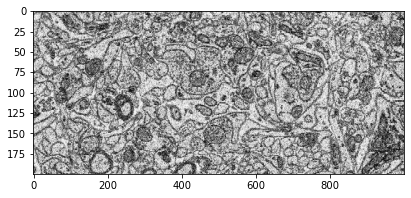

In [ ]:
plt.figure(figsize=(7, 3))
plt.imshow(warped2_xyz[:, 500, :].T, cmap=plt.cm.Greys_r, aspect=(1000 * 11) / (200 * 25))

... or interactively.

In [ ]:
import neuroglancer

dimensions = neuroglancer.CoordinateSpace(names=['x', 'y', 'z'], units='nm', scales=[11, 11, 25])
viewer = neuroglancer.Viewer()
with viewer.txn() as s:
  s.dimensions = dimensions
  s.layers['em'] = neuroglancer.ImageLayer(source=neuroglancer.LocalVolume(warped2_xyz, dimensions))

viewer